In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np

# Question 1 Exploratory Data Analysis 

In [2]:
data = pd.read_csv("compustat.zip")[["sic","datacqtr","cusip","cshoq","saleq","prccq"]]

In [3]:
data["mktcap"]=data["cshoq"]*data["prccq"]
data.head()

,sic,datacqtr,cusip,cshoq,saleq,prccq,mktcap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


In [4]:
saleq_mean , mktcap_mean = data["saleq"].dropna().mean() , data["mktcap"].dropna().mean()
saleq_std , mktcap_std = data["saleq"].dropna().std() , data["mktcap"].dropna().std()
saleq_nan , mktcap_nan = data["saleq"].isna().sum() , data["mktcap"].isna().sum()

In [5]:
df = pd.DataFrame(data=[[saleq_mean,mktcap_mean],[saleq_std,mktcap_std],[saleq_nan,mktcap_nan],[saleq_nan/data.shape[0],mktcap_nan/data.shape[0]]],
                  index=["mean","std","number of NaN","ratio of NaN"],columns=["saleq","mktcap"])
df

,saleq,mktcap
mean,445.150664,2057.473104
std,2679.706576,13202.197457
number of NaN,269498.000000,468276.000000
ratio of NaN,0.148787,0.258530


<font size=4>1. By looking at the standard deviation, both std are very large so it is certain that there are outliers for these two values.</font>

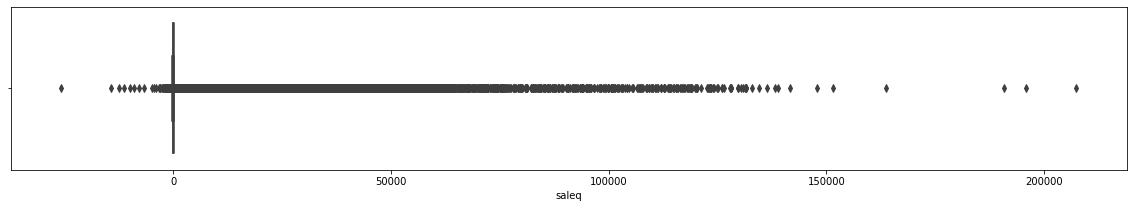

In [6]:
#2(i). Using Boxplot to detect outliers
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize =(20,3))
sns.boxplot(x=data['saleq'])

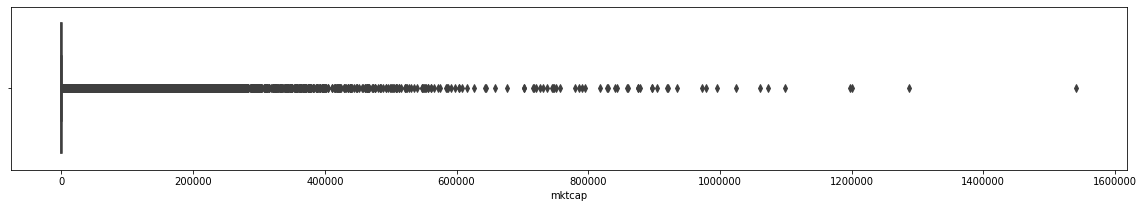

In [7]:
plt.figure(figsize =(20,3))
sns.boxplot(x=data['mktcap'])

In [8]:
#2(ii). Using Z-Score to detect outliers
from scipy import stats
z_saleq,z_mktcap = sum(np.abs(stats.zscore(data["saleq"].dropna())) > 3),sum(np.abs(stats.zscore(data["mktcap"].dropna())) > 3)
print("number of outliers: saleq -",z_saleq,", mktcap -",z_mktcap)

number of outliers: saleq - 15098 , mktcap - 12626


<font size=4>3. There are many outliers for both saleq and mktcap. Since there are 38314 different companies in the dataset with both large and small saleq/mktcap, once we group them together, it is certain that many values will look like "outliers". It might be better if we group the data by their cusip and have more meaningful results. </font>



In [9]:
data["cusip"].unique().shape

(38314,)

<font size=4>4. Since we have 38314 different companies in the dataset, the mean and std we calculated in the table does not give much meaningful information about our dataset.</font>

In [10]:
data["cusip"].unique()[:10]

array(['000032102', '000165100', '000354100', '000361105', '000370106',
       '000736108', '000774109', '000775106', '000781104', '00099V004'],
      dtype=object)

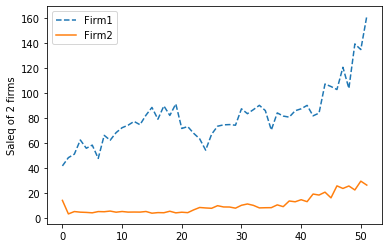

In [11]:
firm1_saleq = data["saleq"][data["cusip"]=='00099V004'].dropna()
firm2_saleq = data["saleq"][data["cusip"]=='000781104'].dropna()
num_of_values = min(firm1_saleq.shape[0],firm2_saleq.shape[0])

plt.plot([i for i in range(num_of_values)],firm1_saleq.values[:num_of_values],label="Firm1",linestyle="dashed")
plt.plot([i for i in range(num_of_values)],firm2_saleq.values[:num_of_values],label="Firm2")
plt.ylabel("Saleq of 2 firms")
plt.legend()

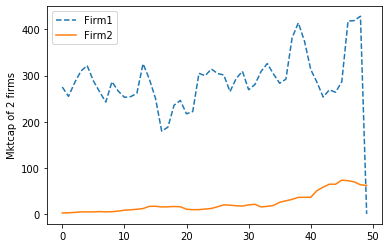

In [12]:
firm1_mktcap = data["mktcap"][data["cusip"]=='00099V004'].dropna()
firm2_mktcap = data["mktcap"][data["cusip"]=='000781104'].dropna()
num_of_values = min(firm1_mktcap.shape[0],firm2_mktcap.shape[0])

plt.plot([i for i in range(num_of_values)],firm1_mktcap.values[:num_of_values],label="Firm1",linestyle="dashed")
plt.plot([i for i in range(num_of_values)],firm2_mktcap.values[:num_of_values],label="Firm2")
plt.ylabel("Mktcap of 2 firms")
plt.legend()

<font size=4> 4. From the above graphs it is clear to see that the values of saleq/mktcap for the random picked two firms vary a lot. </font>

# Question 2 Compute Industry Concentration

In [13]:
# Create copy to avoid modifying the original data
df_HHI = pd.DataFrame(data,columns=["sic","datacqtr","mktcap"]).dropna()

# Add 2 digits sic code
df_HHI["2d-sic"] = [str(i)[:2] for i in df_HHI["sic"]]

# Get time series of industry market cap
industryCap = df_HHI.groupby(["2d-sic","datacqtr"])["mktcap"].sum().reset_index()

# Aggregate data
df_HHI = pd.merge(df_HHI,industryCap,on=["2d-sic","datacqtr"])
df_HHI.rename(columns={"mktcap_x":"mktcap_company","mktcap_y":"mktcap_industry"},inplace=True)

# Calculate HHI
df_HHI["HHI"] = (df_HHI['mktcap_company']/df_HHI["mktcap_industry"]*100)**2
industryHHI = df_HHI.groupby(["datacqtr","2d-sic"])["HHI"].sum()
industryHHI.head()

datacqtr  2d-sic
1962Q1    45        10000.000000
          60          564.058299
1962Q2    40         3013.961261
          45        10000.000000
          60          543.295514
Name: HHI, dtype: float64

In [14]:
industryHHI_mean = industryHHI.groupby(["2d-sic"]).mean()
industryHHI_mean.head()

2d-sic
10     899.343657
12    2357.157959
13     716.409475
14    3108.287380
15    1099.529501
Name: HHI, dtype: float64

In [15]:
industryHHI_mean = industryHHI_mean[industryHHI_mean<10000].sort_values(ascending=False)
industryHHI_mean.head()

2d-sic
81    9362.460875
90    9237.889784
84    9200.079235
41    7460.903331
76    6585.237355
Name: HHI, dtype: float64

Text(0.5, 1.0, 'HHI of industry 41')

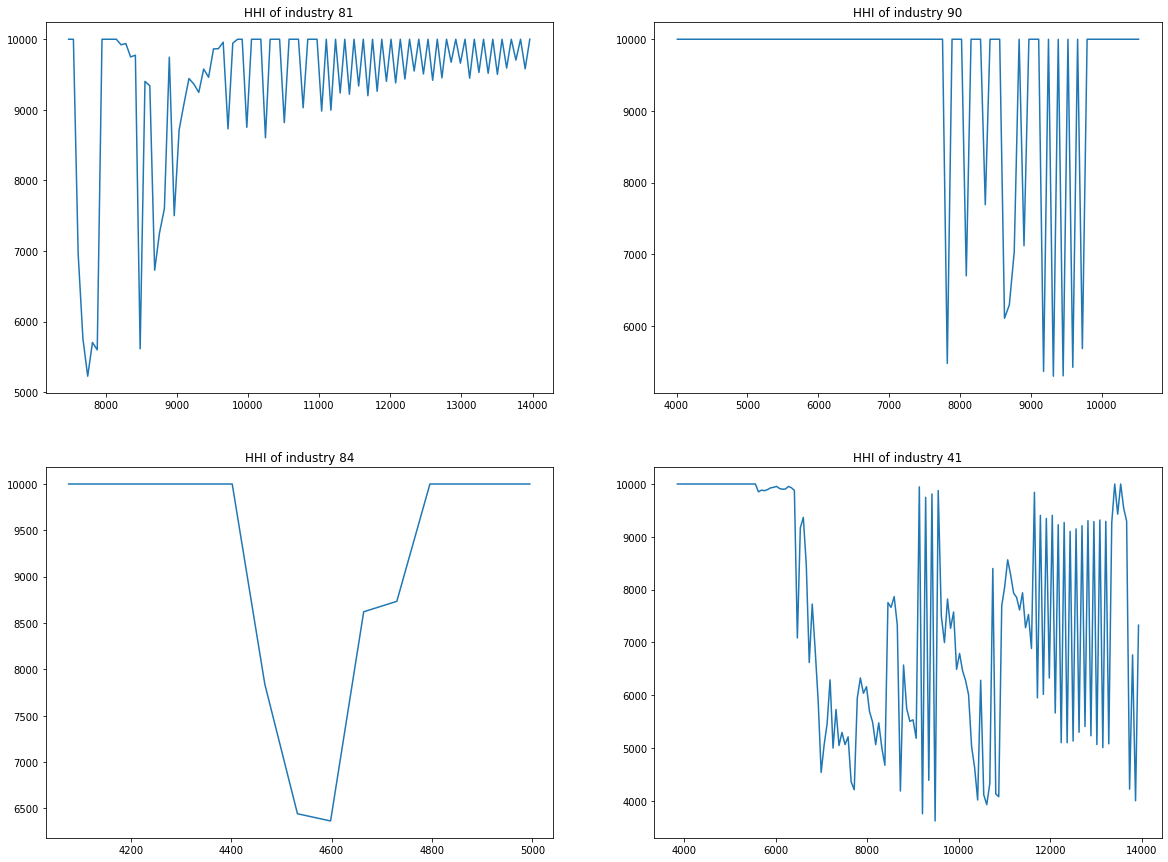

In [16]:
# Transform a multi-indexed series to a dataframe
HHI_ts = pd.DataFrame(industryHHI) #HHI_ts contains time series data of industry HHI
HHI_ts.reset_index(inplace=True)
ind_81 = HHI_ts[HHI_ts["2d-sic"]=="81"]
ind_90 = HHI_ts[HHI_ts["2d-sic"]=="90"]
ind_84 = HHI_ts[HHI_ts["2d-sic"]=="84"]
ind_41 = HHI_ts[HHI_ts["2d-sic"]=="41"]

plt.figure(figsize=(20,15))
ax1 = plt.subplot(2,2,1)
plt.plot(ind_81.index,ind_81["HHI"])
plt.title("HHI of industry 81")

ax2 = plt.subplot(2,2,2)
plt.plot(ind_90.index,ind_90["HHI"])
plt.title("HHI of industry 90")

ax3 = plt.subplot(2,2,3)
plt.plot(ind_84.index,ind_84["HHI"])
plt.title("HHI of industry 84")

ax4 = plt.subplot(2,2,4)
plt.plot(ind_41.index,ind_41["HHI"])
plt.title("HHI of industry 41")